# Simulate Arbitrary Trajectory on CatBot

In [1]:
import numpy as np

from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
)

from matplotlib import pyplot as plt

from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import ModelVisualizer
from pydrake.trajectories import PiecewisePolynomial

## Polynomial Demo
Example code to show how a polynomial can be made.

<pydrake.trajectories.PiecewisePolynomial_[float] object at 0x1762dc230>
0.0
20.0


Text(0, 0.5, 'value')

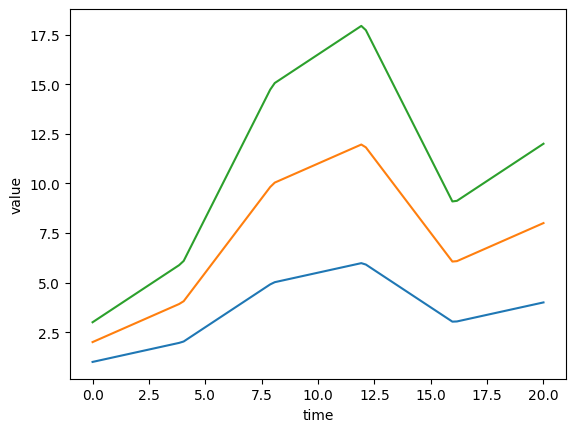

In [2]:
samples = np.array([
    [1, 2, 3],
    [2, 4, 6],
    [5, 10, 15],
    [6, 12, 18],
    [3, 6, 9],
    [4, 8, 12],
]).T


polynomial = PiecewisePolynomial.FirstOrderHold([t * 4.0 for t in range(samples.shape[1])], samples)
print(polynomial)

# Plot the points in polynomial
print(polynomial.start_time())
print(polynomial.end_time())

knots = np.linspace(polynomial.start_time(), polynomial.end_time(), 100)
values = np.hstack([polynomial.value(t) for t in knots])

fig, ax = plt.subplots()
ax.plot(knots, values[0, :])
ax.plot(knots, values[1, :])
ax.plot(knots, values[2, :])
ax.set_xlabel("time")
ax.set_ylabel("value")

## Test with acrobot system

In [3]:
from pydrake.examples import (
    PendulumPlant,
    PendulumState, 
)

from pydrake.all import (
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    MultibodyPlant,
    SceneGraph,
    TrajectorySource,
    MultibodyPositionToGeometryPose,
    PlanarSceneGraphVisualizer
)

from jupyter import AdvanceToAndVisualize

simulating...  done.
generating animation...


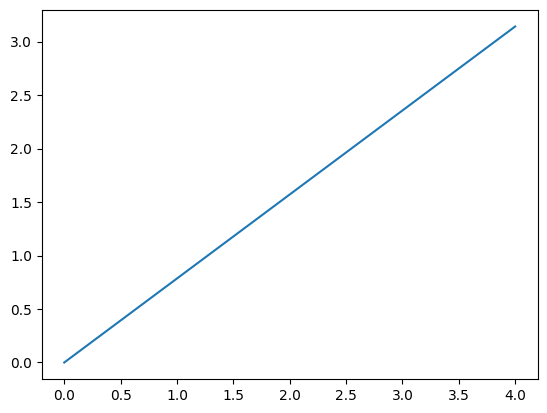

In [19]:
def cartpole_test():
    plant = MultibodyPlant(time_step=0.0)
    scene_graph = SceneGraph()
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant=plant)
    parser.AddModelFromFile("./cartpole.urdf")
    # parser.AddModelFromFile("./catBot.urdf")
    plant.Finalize()


    # -- Trajectory Stuff -- #
    inital_u = (0.0)
    final_u = (np.pi)

    u_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((inital_u, final_u))
    )

    inital_state = (0.0, 0.0, 0.0, 0.0)
    final_state = (np.pi, np.pi, np.pi, np.pi)

    x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((inital_state, final_state))
    )

    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_values = np.hstack([u_trajectory.value(t) for t in times])

    fig, ax = plt.subplots()
    ax.plot(times, u_values[0, :])

    # -- Animation -- #
    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    builder.AddSystem(scene_graph)
    pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
    builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
    builder.Connect(
        pos_to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id())
    )

    visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(
        scene_graph,
        xlim=[-2.5, 2.5],
        ylim=[-1, 2.5],
        show=False
    ))

    builder.Connect(
        scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    )
    simulator = Simulator(builder.Build())

    AdvanceToAndVisualize(simulator, visualizer, x_trajectory.end_time())

cartpole_test()

In [25]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


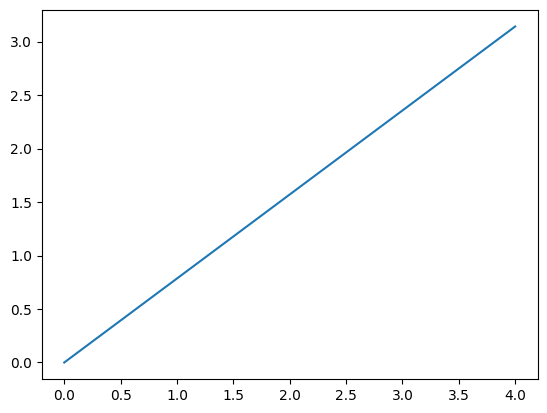

In [61]:
def catBot_test():
    plant = MultibodyPlant(time_step=0.0)
    scene_graph = SceneGraph()
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant=plant)
    parser.AddModelFromFile("./catBot.urdf")
    plant.Finalize()


    # -- Trajectory Stuff -- #
    inital_u = (0.0)
    final_u = (np.pi)

    u_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((inital_u, final_u))
    )

    inital_state = (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    # final_state = (np.pi, np.pi, np.pi, np.pi, np.pi, np.pi)
    # final_state = (np.pi, np.pi/2, np.pi, np.pi, np.pi, np.pi)
    final_state= (np.pi/2, np.pi/2, np.pi/2, 0.0, 0.0, 0.0)
    # final_state = (A position, hinge position, B position, A velocity, hinge velocity, B velocity)

    x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], np.column_stack((inital_state, final_state))
    )

    times = np.linspace(u_trajectory.start_time(), u_trajectory.end_time(), 100)
    u_values = np.hstack([u_trajectory.value(t) for t in times])

    fig, ax = plt.subplots()
    ax.plot(times, u_values[0, :])

    # -- Animation -- #
    builder = DiagramBuilder()
    source = builder.AddSystem(TrajectorySource(x_trajectory))
    builder.AddSystem(scene_graph)
    pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant, input_multibody_state=True))
    builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
    builder.Connect(
        pos_to_pose.get_output_port(),
        scene_graph.get_source_pose_port(plant.get_source_id())
    )

    # visualizer = builder.AddSystem(ModelVisualizer(meshcat=meshcat))
    # visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(
    #     scene_graph,
    #     xlim=[-2.5, 2.5],
    #     ylim=[-1, 2.5],
    #     show=False
    # ))

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph.get_query_output_port(),
    meshcat)

    # builder.Connect(
    #     scene_graph.get_query_output_port(), visualizer.get_input_port(0)
    # )
    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    start_state = context.get_continuous_state()

    simulator.set_target_realtime_rate(1.0)
    meshcat.AddButton("Stop Simulation", "Escape")
    # meshcat.AddButton("Reset Simulation", "r")

    while meshcat.GetButtonClicks("Stop Simulation") < 1:
        simulator.AdvanceTo(simulator.get_context().get_time() + 2.0)
        if simulator.get_context().get_time() > 6.0:
            break
        # if meshcat.GetButtonClicks("Reset Simulation") > 0:
        #     context.SetTime(0.0)
        #     # context.SetContinuousState(start_state)
        

    meshcat.DeleteButton("Stop Simulation")

catBot_test()